# Data Load

In [75]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset, Subset
import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import ImageOps


In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Combine Datasets

In [48]:
def split_data(data, train_ratio = 0.8, valid_ratio = 0.1):
    random.seed = 1773

    # Shuffle indices of data
    total_data_len = len(data)
    indices = list(range(total_data_len))
    random.shuffle(indices)

    # Sizes of the train, test, val
    train_size = int(train_ratio * total_data_len)
    valid_size = int(valid_ratio * total_data_len)
    test_size = total_data_len - train_size - valid_size

    # Chosing indices for splitting
    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size + valid_size]
    test_indices = indices[train_size + valid_size:]
    
    # Choosing subsets according to indices
    #Therefore we can split data randomly
    train_dataset = Subset(data, train_indices)
    valid_dataset = Subset(data, valid_indices)
    test_dataset = Subset(data, test_indices)
    
    return train_dataset, valid_dataset, test_dataset

In [49]:
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [71]:
class Custom_Dataset(Dataset):
    def __init__(self, dataset, transform = transform_image, mask_prob = 0.2, patch_size = 16):
        self.dataset = dataset
        self.transform = transform
        self.mask_prob = mask_prob  # Probability of the masking an image
        self.patch_size = patch_size       
    
    def __len__(self):
        return(len(self.dataset))
    
    def __getitem__(self, index):
        image = self.dataset[index][0]
        image = ImageOps.exif_transpose(image)  # Rotate the image if it has exif data

        image = self.transform(image)

        masked_image, mask = self.create_mask(image)

        return image, masked_image, mask

        
    def create_mask(self, image):
        masked_image = image.clone()
        random.seed = 1773
        _, height, width = image.shape

        # Calculate the number of patches
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        

        # An array shape like image
        # True for positions of the mask
        # False for rest of the array
        mask = torch.zeros((num_patches_h * num_patches_w), dtype=torch.bool)
        
        for i in range(num_patches_h):
            for j in range(num_patches_w):
                if random.random() < self.mask_prob:
                    x_min, x_max = i * self.patch_size,  (i+1) * self.patch_size
                    y_min, y_max = j * self.patch_size,  (j+1) * self.patch_size

                    masked_image[:, x_min:x_max, y_min:y_max] = 0
                    mask[i * num_patches_w + j] = True
                    
        return masked_image, mask
    


In [72]:
dataset1 = datasets.ImageFolder(
    root = r"C:\Users\user\Desktop\Datasets_for_Projects\celeba",
)

dataset2 = datasets.ImageFolder(
    root = r"C:\Users\user\Desktop\Datasets_for_Projects\places",
)
random.seed = 1773
custom_data1 = Custom_Dataset(dataset1, transform=transform_image)
custom_data2 = Custom_Dataset(dataset2, transform=transform_image)

# Combine two datasets
combined_dataset = ConcatDataset([custom_data1, custom_data2])

# Split the dataset into train, validation and test
train_dataset, valid_dataset, test_dataset = split_data(combined_dataset)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [81]:
# Collected photo dataset
dataset_collected = datasets.ImageFolder(root="./Collected_Photo")
custom_data_collected = Custom_Dataset(dataset_collected, transform=transform_image)


collected_loader = DataLoader(custom_data_collected, batch_size=16, shuffle=False)  

In [54]:
image_celeba = dataset1[0] 
image_places = dataset2[0]
image_collected = dataset_collected[0]

image_celeba_np = np.array((image_celeba[0]))
image_places_np = np.array((image_places[0]))
image_collected_np = np.array((image_collected[0]))

print(f"Before Transformation: \n")
print(f"Pixel range of the image from Celeba dataset: {image_celeba_np.min()} - {image_celeba_np.max()}")
print(f"Pixel range of the image from Places dataset: {image_places_np.min()} - {image_places_np.max()}")
print(f"Pixel range of the image from Collected dataset: {image_collected_np.min()} - {image_collected_np.max()} \n")

print(f"Shape of the image from Celeba dataset: {image_celeba_np.shape}")
print(f"Shape of the image from Places dataset: {image_places_np.shape}")
print(f"Shape of the image from Collected dataset: {image_collected_np.shape}")

image_celeba = transform_image(image_celeba[0])
image_places = transform_image(image_places[0])
image_collected = transform_image(image_collected[0])

print(f"\nAfter Transformation: \n")

print(f"Pixel range of the image from Celeba dataset: {image_celeba.min()} - {image_celeba.max()}")
print(f"Pixel range of the image from Places dataset: {image_places.min()} - {image_places.max()}")
print(f"Pixel range of the image from Collected dataset: {image_collected.min()} - {image_collected.max()} \n")

print(f"Shape of the image from Celeba dataset: {image_celeba.shape}")
print(f"Shape of the image from Places dataset: {image_places.shape}")
print(f"Shape of the image from Collected dataset: {image_collected.shape}")


Before Transformation: 

Pixel range of the image from Celeba dataset: 0 - 255
Pixel range of the image from Places dataset: 0 - 255
Pixel range of the image from Collected dataset: 0 - 255 

Shape of the image from Celeba dataset: (218, 178, 3)
Shape of the image from Places dataset: (256, 256, 3)
Shape of the image from Collected dataset: (900, 1600, 3)

After Transformation: 

Pixel range of the image from Celeba dataset: -1.0 - 1.0
Pixel range of the image from Places dataset: -1.0 - 1.0
Pixel range of the image from Collected dataset: -0.9921568632125854 - 1.0 

Shape of the image from Celeba dataset: torch.Size([3, 224, 224])
Shape of the image from Places dataset: torch.Size([3, 224, 224])
Shape of the image from Collected dataset: torch.Size([3, 224, 224])


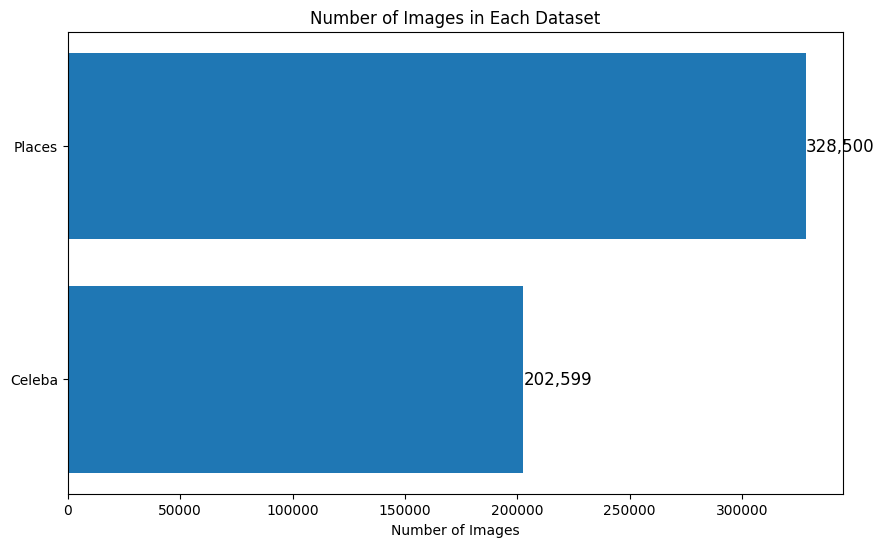

In [ ]:
# Plotting the images count in each dataset
counts = (len(dataset1), len(dataset2)) 
plt.figure(figsize=(10, 6))
bars = plt.barh(["Celeba", "Places"], counts)
plt.xlabel("Number of Images")
plt.title("Number of Images in Each Dataset")

for bar, count in zip(bars, counts):
    plt.text(count + 100, bar.get_y() + bar.get_height()/2, 
             f"{count:,}", ha='left', va='center', fontsize=12)

plt.show()

## Example of Mask

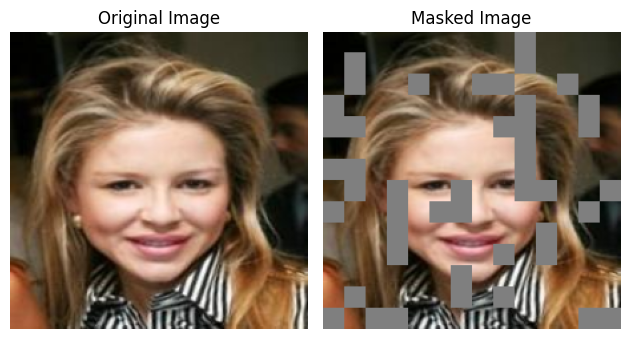

In [ ]:
def unnormalize_and_convert(image):
    image = image.permute(1, 2, 0).cpu().detach().numpy()  
    image = (image * 0.5) + 0.5  
    image = np.clip(image, 0, 1)  
    return image

# Take a random image from the train dataset
original_image, masked_image, mask = train_dataset[random.randint(0,2000)]  

plt.figure()

# Plot the original and masked image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(unnormalize_and_convert(original_image))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Masked Image")
plt.imshow(unnormalize_and_convert(masked_image))
plt.axis('off')

plt.tight_layout()
plt.show()


# Transformer

In [57]:
from transformers import ViTModel
from transformers import ViTConfig
from tqdm import tqdm
from torchvision.models import vgg16
from pytorch_msssim import SSIM
from IPython.display import clear_output
import os
import csv

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
class ViT_decoder(nn.Module):
    def __init__(self, pretrained_model_name="google/vit-base-patch16-224-in21k"):
        super(ViT_decoder, self).__init__()
        # Load the pretrained ViT model and configure it
        config = ViTConfig(image_size=224, patch_size=16, hidden_size=768, 
                           num_hidden_layers=4, num_attention_heads=4)

        self.vit = ViTModel.from_pretrained(pretrained_model_name, config= config)
        
        # Freeze the parameters of the ViT model
        for param in self.vit.parameters():
            param.requires_grad = False
        for param in self.vit.encoder.parameters():
            param.requires_grad = True
        
    
        # Decoder part for image reconstruction
        self.decoder = nn.Sequential(
            # Transpose Convolutional layers 1
            nn.ConvTranspose2d(self.vit.config.hidden_size, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            # Transpose Convolutional layers 2
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            # Transpose Convolutional layers 3
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),  # Final layer for RGB
        )

    def forward(self, image, mask):
        # Get the output from the ViT model
        output = self.vit(image).last_hidden_state
        output = output[:, 1:, :]
        
        batch_size, seq_len, hidden_dim = output.shape
        patch_size = int(seq_len**0.5)
        
        output = output.permute(0, 2, 1).view(batch_size, hidden_dim, patch_size, patch_size)
        output = self.decoder(output)

        return output

## Plot Sample Image

In [59]:
def plot_sample_image(original_image, masked_image, inpainted_image, expanded_mask, save_path=None, image_name=None):   
    clear_output(wait=True)     # Clear the previous output (If don't clear out of memory error occurs in the training)
    # Plot the original, masked and inpainted image
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(unnormalize_and_convert(original_image))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(unnormalize_and_convert(masked_image))
    ax[1].set_title("Masked Image")
    ax[1].axis('off')

    inpainted_image = inpainted_image * expanded_mask + masked_image
    ax[2].imshow(unnormalize_and_convert(inpainted_image))
    ax[2].set_title("Inpainted Image")
    ax[2].axis('off')
    
    plt.tight_layout()
    # Save the image if save_path and image_name is provided
    if save_path and image_name is not None:
        os.makedirs(save_path, exist_ok=True)  # Ensure directory exists
        file_path = os.path.join(save_path, image_name)
        plt.savefig(file_path)
        print(f"Saved: {file_path}")
    plt.show()

## Performance Metrics

In [60]:
def psnr(output, target, mask):
    """Compute PSNR (Peak Signal-to-Noise Ratio)"""
    # Apply mask to output and target
    output = output * mask
    target = target * mask
    # Calculate the Mean Squared Error
    mse = torch.mean((output - target) ** 2, dim=(1, 2, 3))
    mse = torch.where(mse == 0, torch.tensor(1e-10).to(mse.device), mse)
    # calculate PSNR
    psnr_value = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr_value.mean().item()

def pixel_accuracy(output, target, mask):
    # Apply mask to output and target
    output = output * mask
    target = target * mask
    # Calculate the pixel accuracy
    correct = (torch.abs(output - target) < 1).float()
    denominator = mask.sum(dim=(1, 2, 3))
    denominator = torch.where(denominator == 0, torch.tensor(1.0).to(denominator.device), denominator)
    acc_per_image = correct.sum(dim=(1, 2, 3)) / denominator
    return acc_per_image.mean().item()


## Loss Functions

In [61]:
import torch.nn.functional as F
from torchvision.models import vgg11

class LightweightPerceptualLoss(nn.Module):
    def __init__(self):
        # Load the VGG11 model and use the first 8 layers
        super(LightweightPerceptualLoss, self).__init__()
        vgg = vgg11(pretrained=True).features[:8]
        # Freeze the parameters of the VGG model
        self.feature_extractor = nn.Sequential(*list(vgg))
        for param in self.feature_extractor.parameters():
            param.requires_grad = False 

    def forward(self, output, target):
        # Get the feature maps from the VGG model
        output_features = self.feature_extractor(output)
        target_features = self.feature_extractor(target)
        loss = F.mse_loss(output_features, target_features)  # MSE between feature maps
        return loss

In [62]:
class CombinedLoss(nn.Module):
    def __init__(self, perceptual_weight=0.3, ssim_weight=0.7):
        super(CombinedLoss, self).__init__()
        # Initialize the perceptual loss and SSIM loss
        self.perceptual_loss = LightweightPerceptualLoss()
        self.ssim_loss = SSIM(data_range=1, size_average=True, channel=3)
        self.perceptual_weight = perceptual_weight
        self.ssim_weight = ssim_weight

    def forward(self, output, target, expanded_mask):
        # Apply mask to output and target
        masked_output = output * expanded_mask
        masked_target = target * expanded_mask
        # Calculate the SSIM loss and perceptual loss
        ssim_loss = 1 - self.ssim_loss(masked_output, masked_target)
        perceptual_loss = self.perceptual_loss(output, target)
        total_loss = self.ssim_weight * ssim_loss + self.perceptual_weight * perceptual_loss
        return total_loss

## Train Model

In [63]:
def save_checkpoint(epoch, model, optimizer, scaler, best_valid_loss, path="checkpoint.pth"):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict(),
        "best_valid_loss": best_valid_loss,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved: {path}")



In [64]:
def train_model(model, optimizer, scaler, start_epoch, best_valid_loss, train_loader, valid_loader, num_epochs=1, device="cuda"):
    
    # Early stopping parameters
    patience = 3
    patience_counter = 0

    # Move the model to the device
    model.to(device)
    criterion = CombinedLoss().to(device)


    model.train()

    for epoch in range(start_epoch, start_epoch + num_epochs):
        # Initialize the training loss and accuracy, MSE and PSNR 
        train_loss = 0.0
        train_PSNR = 0.0
        train_accuracy = 0.0
        train_MSE = 0.0
        plot_counter = 1
        idx = 0

        for images, masked_images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}, Train"):
            plot_counter -= 1
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)
            # Expand the mask to the size of the image
            # Mask is 16x16, true/false matrix
            # Expand it to 224x224
            expanded_mask = masks.view(masks.size(0),14, 14)
            expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
            expanded_mask = expanded_mask.unsqueeze(1).float()
            
            # Zero the parameter gradients
            # Also scale the loss to avoid gradient explosion
            # Use autocast to automatically use mixed precision
            # This reduces memory usage and speeds up training
            with torch.amp.autocast("cuda"):
                outputs = model(masked_images, masks)  
                loss = criterion(outputs, images, expanded_mask)

            
            # Calculate the PSNR and pixel accuracy, MSE
            batch_psnr = psnr(outputs, images, expanded_mask)
            batch_accuracy = pixel_accuracy(outputs, images, expanded_mask) 
            train_PSNR += batch_psnr
            train_accuracy += batch_accuracy
            train_loss += loss.item()
            train_MSE += F.mse_loss(outputs* expanded_mask, images * expanded_mask).item()

            # Plot the sample image for every 1500 iterations
            if(plot_counter == 0):
                plot_counter = 1500
                idx += 1
                plot_sample_image(images[0], masked_images[0], outputs[0], expanded_mask[0], "Transformer\Training_Images", f"Epoch_{epoch + 1}_idx_{idx}.png")

            # Backward and optimize
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
        # Calculate the average training loss, PSNR, accuracy, MSE
        avg_train_loss = train_loss / len(train_loader)
        avg_train_PSNR = train_PSNR / len(train_loader)
        avg_accuracy = train_accuracy / len(train_loader)
        avg_train_MSE = train_MSE / len(train_loader)
        
        print(f"Epoch {epoch + 1}, Loss: {avg_train_loss:.4f}, PSNR: {avg_train_PSNR:.4f}, Accuracy: {avg_accuracy:.4f}, MSE: {avg_train_MSE:.4f}")
        
        # Validation and rest is same with the training
        model.eval()
        val_loss = 0.0
        val_PSNR = 0.0
        val_accuracy = 0.0
        val_MSE = 0.0
        aaa = True
        with torch.no_grad():
            for images, masked_images, masks in tqdm(valid_loader, desc=f"Epoch {epoch + 1},  Validation"):
                images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

                expanded_mask = masks.view(masks.size(0),14, 14)
                expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
                expanded_mask = expanded_mask.unsqueeze(1).float()
                outputs = model(masked_images, masks)
                loss = criterion(outputs, images, expanded_mask)
                
                batch_psnr = psnr(outputs, images, expanded_mask)
                batch_accuracy = pixel_accuracy(outputs, images, expanded_mask) 
                
                val_PSNR += batch_psnr
                val_accuracy += batch_accuracy
                # Plot the sample image for the first batch
                if(aaa == True):
                    aaa = False
                    plot_sample_image(images[0], masked_images[0], outputs[0], expanded_mask[0],
                                      "Transformer\Validation Images", f"Epoch_{epoch + 1}.png")

                val_loss += loss.item()
                val_MSE += F.mse_loss(outputs* expanded_mask, images * expanded_mask).item()
        
        avg_val_loss = val_loss / len(valid_loader)
        avg_val_PSNR = val_PSNR / len(valid_loader)
        avg_val_accuracy = val_accuracy / len(valid_loader)
        avg_val_MSE = val_MSE / len(valid_loader)

        print(f"Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_PSNR:.4f}, Accuracy: {avg_val_accuracy:.4f}, MSE: {avg_val_MSE:.4f}")
        
        # Save the model if the validation loss is improved
        if avg_val_loss < best_valid_loss:
            best_valid_loss = avg_val_loss
            patience_counter = 0
            save_checkpoint(epoch + 1, model, optimizer, scaler, best_valid_loss, path="best_model_transformer.pth")
            print(f"Model improved and saved")
        else:
            patience_counter += 1
            if patience_counter > patience:
                print("Early stopping")
                break

        # Save the training metrics to a csv file
        log_file = "training_metrics.csv"
        with open(log_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, avg_train_loss, avg_val_loss, avg_train_PSNR, avg_val_PSNR, avg_accuracy, avg_val_accuracy, avg_train_MSE, avg_val_MSE])






# Create the model, optimizer and scaler
model = ViT_decoder().to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scaler = torch.amp.GradScaler("cuda")

# this variable is used to determine whether the model is trained before or not
# 0: Not trained before
# 1: Trained before and continue training
# 2: Trained before and do not continue training
trained_before = 2
if (trained_before == 0):
    train_model(model, optimizer, scaler, 0, float('inf'), train_loader, valid_loader, 20, device=device)
elif(trained_before == 1):
    checkpoint = torch.load("best_model_transformer.pth", map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scaler.load_state_dict(checkpoint["scaler_state_dict"])
    start_epoch = checkpoint["epoch"]
    best_valid_loss = checkpoint["best_valid_loss"]
    best_valid_loss = float(best_valid_loss)
    train_model(model, optimizer, scaler, start_epoch, best_valid_loss, train_loader, valid_loader, 4, device)
else:
    pass

## Load Best Transformer

In [ ]:
model.load_state_dict(torch.load("best_model_transformer.pth")["model_state_dict"])



C:\Users\user\AppData\Local\Temp\ipykernel_25384\3819931890.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth")["model_sta

<All keys matched successfully>

## Evaluate

Saved: Transformer\Test Images\Image_751.png


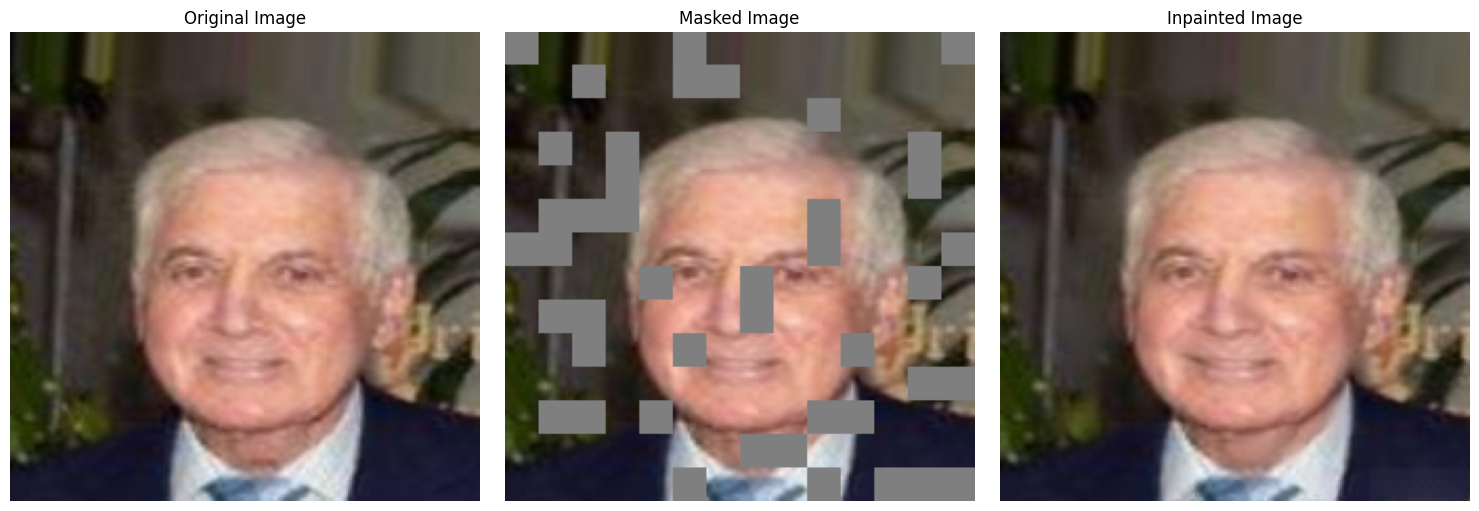

In [86]:
def evaluate(model, dataloader, criterion, device= "cuda", sample_size=5):
    # Move the model to the device
    model.eval()

    # Initialize the test loss, accuracy, PSNR, MSE
    test_loss = 0.0
    test_accuracy = 0.0
    test_PSNR = 0.0
    test_MSE = 0.0

    # Choose random indices for the sample images
    random_indices = random.sample(range(len(dataloader)), sample_size)

    with torch.no_grad():
        for idx, (images, masked_images, masks) in enumerate(dataloader):
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)
            # Expand the mask to the size of the image
            expanded_mask = masks.view(masks.size(0),14, 14)
            expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
            expanded_mask = expanded_mask.unsqueeze(1).float()

            outputs = model(masked_images, masks)
            loss = criterion(outputs, images, expanded_mask)
            
            batch_psnr = psnr(outputs, images, expanded_mask)
            batch_accuracy = pixel_accuracy(outputs, images, expanded_mask)
            # Plot the sample image for the random indices
            if idx in random_indices:
                plot_sample_image(images[0], masked_images[0], outputs[0], expanded_mask[0],
                                  "Transformer\Test Images", f"Image_{idx}.png")
                
            test_loss += loss.item()
            test_MSE += F.mse_loss(outputs* expanded_mask, images * expanded_mask).item()
            test_PSNR += batch_psnr
            test_accuracy += batch_accuracy

        avg_test_loss = test_loss / len(dataloader)
        avg_test_PSNR = test_PSNR / len(dataloader)
        avg_test_accuracy = test_accuracy / len(dataloader)
        avg_test_MSE = test_MSE / len(dataloader)

    return {"test_loss": avg_test_loss, "test_PSNR": avg_test_PSNR, "test_accuracy": avg_test_accuracy, "test_MSE": avg_test_MSE}


criterion = CombinedLoss().to(device)

test_dict = evaluate(model, test_loader, criterion, device=device, sample_size=5)

In [87]:
print(f"Test Loss: {test_dict['test_loss']:.4f}, Test PSNR: {test_dict['test_PSNR']:.4f}, Test Accuracy: {test_dict['test_accuracy']:.4f}, Test MSE: {test_dict['test_MSE']:.4f}")

Test Loss: 0.0762, Test PSNR: 24.8103, Test Accuracy: 15.3206, Test MSE: 0.0046


## Collected Dataset

Saved: Transformer\Collected_Images\Image_179.png


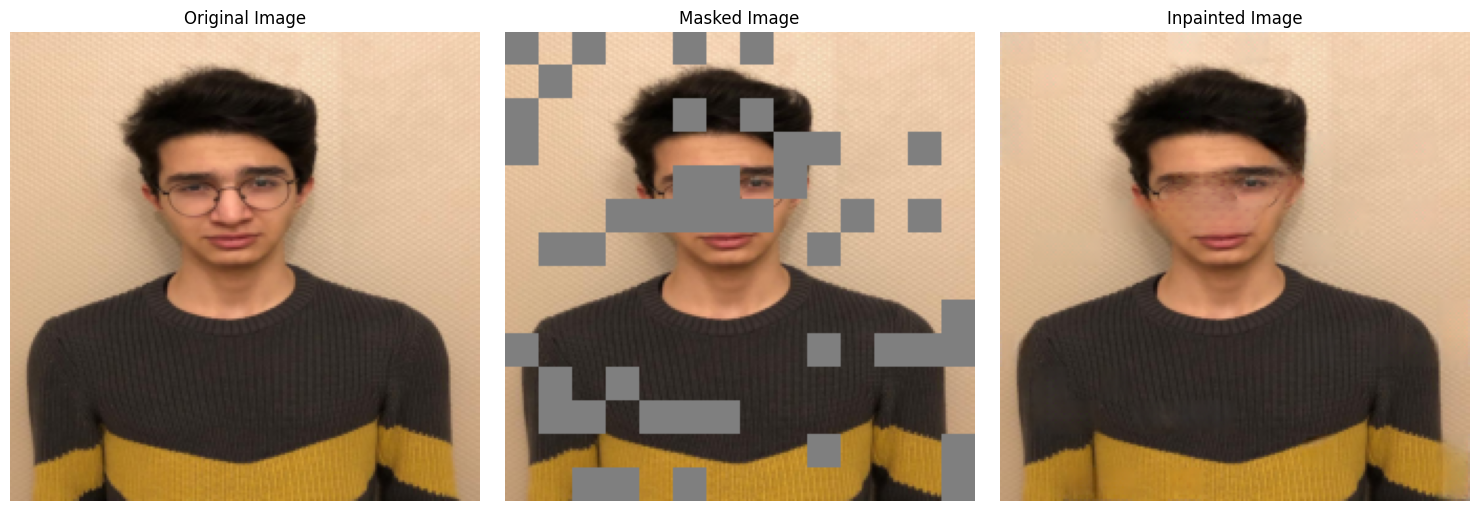

In [84]:
# Same with Test dataset model evaluation but for the collected dataset
# Only difference I save all images in a file
def evaluate(model, dataloader, criterion, device= "cuda"):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    test_PSNR = 0.0
    test_MSE = 0.0
    i = 0
    with torch.no_grad():
        for images, masked_images, masks in dataloader:
            images, masked_images, masks = images.to(device), masked_images.to(device), masks.to(device)

            expanded_mask = masks.view(masks.size(0),14, 14)
            expanded_mask = expanded_mask.repeat_interleave(16, dim=1).repeat_interleave(16, dim=2)
            expanded_mask = expanded_mask.unsqueeze(1).float()

            outputs = model(masked_images, masks)
            loss = criterion(outputs, images, expanded_mask)
            
            batch_psnr = psnr(outputs, images, expanded_mask)
            batch_accuracy = pixel_accuracy(outputs, images, expanded_mask)
            for j in range(len(images)):
                plot_sample_image(images[j], masked_images[j], outputs[j], expanded_mask[j],
                                "Transformer\Collected_Images", f"Image_{i * len(images) + j}.png")
            i += 1
            
            test_loss += loss.item()
            test_MSE += F.mse_loss(outputs* expanded_mask, images * expanded_mask).item()
            test_PSNR += batch_psnr
            test_accuracy += batch_accuracy

        avg_test_loss = test_loss / len(dataloader)
        avg_test_PSNR = test_PSNR / len(dataloader)
        avg_test_accuracy = test_accuracy / len(dataloader)
        avg_test_MSE = test_MSE / len(dataloader)
    
    return {"test_loss": avg_test_loss, "test_PSNR": avg_test_PSNR, "test_accuracy": avg_test_accuracy, "test_MSE": avg_test_MSE}

collected_dict = evaluate(model, collected_loader, criterion, device=device)

In [85]:
print(f"Test Loss: {collected_dict['test_loss']:.4f}, Test PSNR: {collected_dict['test_PSNR']:.4f}, Test Accuracy: {collected_dict['test_accuracy']:.4f}, Test MSE: {collected_dict['test_MSE']:.4f}")

Test Loss: 0.0840, Test PSNR: 24.7724, Test Accuracy: 15.0421, Test MSE: 0.0045


## Curves

In [68]:
# Load the training metrics from the csv file
df = pd.read_csv("training_metrics.csv", index_col=0)
df_loss = df[["Train Loss", "Validation Loss"]]
df_psnr = df[["Train PSNR", "Validation PSNR"]]
df_accuracy = df[["Train Accuracy", "Validation Accuracy"]]
df_mse = df[["Train MSE", "Validation MSE"]]

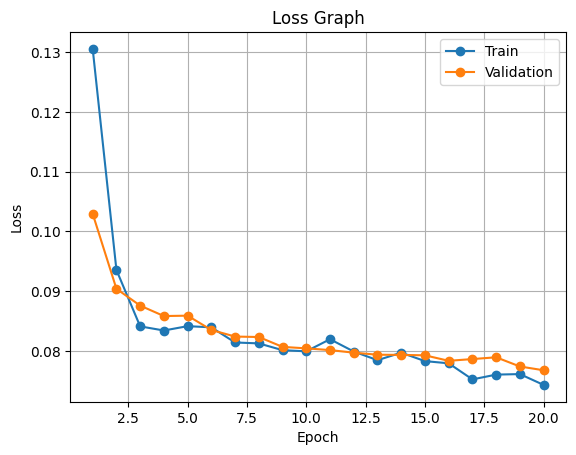

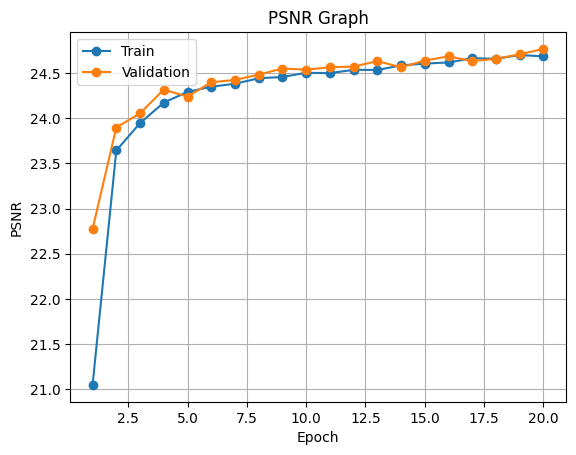

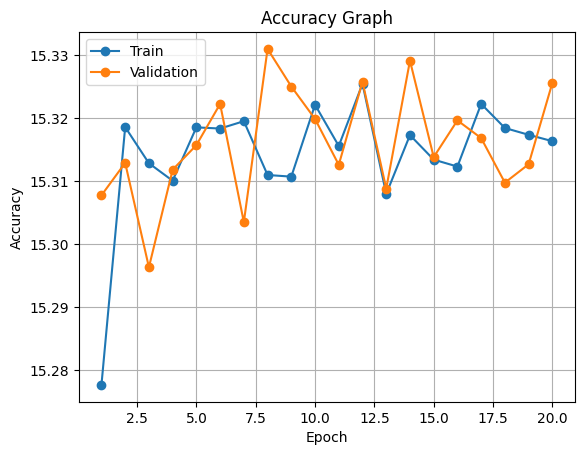

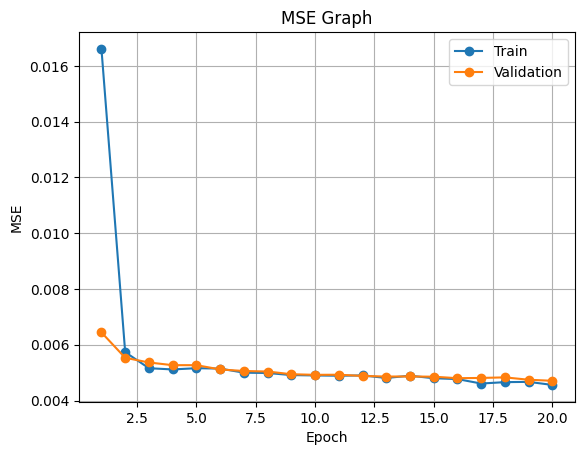

In [ ]:
# Plot the training metrics
def plot_graph(df, name):
    plt.figure()
    plt.plot(df, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel(name)
    plt.legend(["Train", "Validation"])
    plt.title(f"{name} Graph")
    plt.grid()
    plt.show()

# Plot the graphs
plot_graph(df_loss, "Loss")
plot_graph(df_psnr, "PSNR")
plot_graph(df_accuracy, "Accuracy")
plot_graph(df_mse, "MSE")